In [16]:
import numpy as np
import numpy,scipy
import six,nestle
import astropy
from sncosmo.utils import Result, Interp1D,ppf
from scipy.interpolate import interp1d as interp
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as multi_gauss

#---------------------------------------------------------------------

import Library_GraphTwoDimensionDensityColorMap
#---------------------------------------------------------------------

print ("done importing")

done importing


**Data Generation**
==============

In [97]:
#Set the variables for our model, and the model itself
v = 50
g = 10
def my_model( v,g, t):
    return v*t -.5*g*t**2



In [98]:
#(SECRET)
#Pick some times of which to observe the height
times=np.linspace(.1,10,20) # measurement times


#figure out the heights which are "real" for the given times above
perfect_data=my_model(v,g,times)


In [105]:
#What does the experimentalist give us?

#Set the height uncertainty --> This is the entire error function from the experimentalist
#   (we have uncertainty in the same units as the height --> meters)
measurement_uncertainty = 10
errors=np.ones(len(times))*measurement_uncertainty


#Define the measurment error function which is something the experimentalist would give us.
covariance_matrix=np.array(
    [
        [.58,   13.35],
        [13.35, 501.77]
    ])


In [106]:
#(SECRET)
#Generate 1D uncertainty dataset
#   By 1D, we mean that we have only error in the height measurement. 
#   We have NO time measurement error   



#Introduce error into the "perfect" data using the experiment error
heights=np.random.normal(perfect_data,errors)
my_data_1D=Table([times,heights,errors],
              names=('time','height','error'))

#print( my_data_1D )

#Write the generated data to a file on the disk of the computer
astropy.io.ascii.write( my_data_1D, "1D_Generated_Data.astropydat" , overwrite = True )


In [116]:
#(SECRET)
#Generate 1D uncertainty dataset with a model that will not work with
#   a simple chi-square minimization.
#   By 1D, we mean that we have only error in the height measurement. 
#   We have NO time measurement error   .

#Set the variables for our model, and the model itself
v = 50
g = -10
def my_bad_model( v,g, t):
    return v*t -.5*g**2*t**2

#Generate "perfect" data with the bad model.
perfect_bad_data=my_bad_model(v,g,times)
#Introduce error into the "perfect" data using the experiment error
heights_bad=np.random.normal(perfect_bad_data,errors)
my_bad_data_1D=Table([times,heights_bad,errors],
              names=('time','height','error'))

#print( my_data_1D )

#Write the generated data to a file on the disk of the computer
astropy.io.ascii.write( my_bad_data_1D, "1D_Generated_Data_ChiProblem.astropydat" , overwrite = True )

In [107]:
#(SECRET)
#Generate 2D uncertainty dataset
#   By 2D, we mean that we have only error in BOTH
#      the height measurement  
#      AND time measurement error 
#   The errors are not mutually exclusive. 
#   The errors can be thought of as DEPENDENT RANDOM VARIABLES


covariance_matrices=[covariance_matrix]*len(perfect_data)

#Use the measurment error function to take the perfect data, and mess it up
times_2d=[]
heights_2d=[]
for i in range(len(perfect_data)):
    t,f=np.random.multivariate_normal(
                    mean=[times[i],perfect_data[i]],
                    cov=covariance_matrix)
    times_2d.append(t)
    heights_2d.append(f)

my_data_2D=Table([times_2d,heights_2d],names=('time','height'))

#Write the generated data to a file on the disk of the computer
astropy.io.ascii.write( my_data_2D, "2D_Generated_Data.astropydat", overwrite = True )





In [108]:
#Read the generated data from a file, and store as a python variable:
my_data_1D = astropy.io.ascii.read( "1D_Generated_Data.astropydat" )
#print( my_data_1D )

#Read the generated data from a file, and store as a python variable:
my_data_2D = astropy.io.ascii.read( "2D_Generated_Data.astropydat" )
#print( my_data_2D )



In [109]:
def generate_experiment_error_function(mu, cov):
    def experiment_error_function(Point):
        x = Point
        return multi_gauss.pdf(x, mu, cov)
    return experiment_error_function

**Data Plotting**
==============

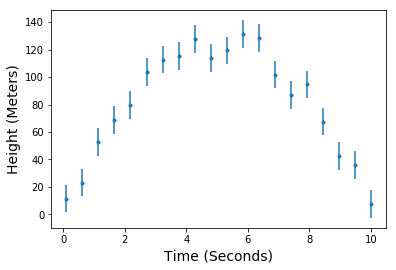

In [110]:
#Plot the 1D data
plt.errorbar( my_data_1D['time'], my_data_1D['height'], yerr =  my_data_1D['error'], fmt = ".")
plt.ylabel('Height (Meters)',fontsize=14)
plt.xlabel('Time (Seconds)',fontsize=14)
plt.show()


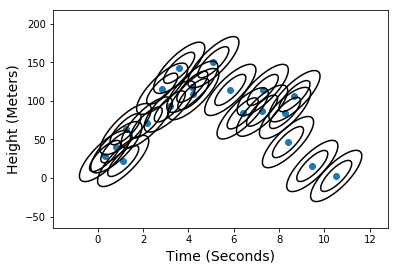

In [14]:
plt.scatter(times_2d,heights_2d)
for i in range(len(times_2d)):
    mu = np.array([times_2d[i],heights_2d[i]])
    cov = covariance_matrix
    Function = generate_experiment_error_function(mu, cov)
    xmin=-3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    xmax=3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    ymin=-3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    ymax=3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    X, Y = numpy.mgrid[xmin:xmax:100j, ymin:ymax:100j] #1000 x 1000 -> 1 million points
    PointsToPlugIn = numpy.vstack([X.ravel(), Y.ravel()])
    PointsToPlugInDataset = PointsToPlugIn.T
    PlugInPointsCount = len(PointsToPlugInDataset)
    FunctionResultValuesForGrid = numpy.zeros((PlugInPointsCount))
    k = 0
    while (k < PlugInPointsCount):
        PointToPlugIn = PointsToPlugInDataset[k]
        FunctionValueForPointToPlugIn = Function(PointToPlugIn)
        FunctionResultValuesForGrid[k] = FunctionValueForPointToPlugIn
        k = k + 1
    Z = numpy.reshape(FunctionResultValuesForGrid, X.shape)
    CS = plt.contour(X, Y, Z, 2,
                             colors='k', # negative contours will be dashed by default
                             )
plt.xlabel('Time (Seconds)',fontsize=14)
plt.ylabel('Height (Meters)',fontsize=14)
plt.show()

**Data Fitting:**
==============

In [111]:
#Let's try and fit the data with a simple chi-square minimization
    
def chisquare(parameters,args):
    #This function accepts a set of model parameters v and g
        #and returns a chi square value, comparing with the 
        #times,observations,errors, and model provided in args
    v,g=parameters
    observed_times,observed_values,observed_errors,model_func=args
    model_values=model_func(v,g,observed_times)
    z = (observed_values - model_values) / observed_errors 
    chi2 = np.sum(z ** 2)
    return(chi2)

my_args=[my_data_1D['time'],my_data_1D['height'],my_data_1D['error'],my_model]
result =  scipy.optimize.minimize(chisquare,[50,50],args=my_args,
                                                  bounds=[(0,100),(0,100)],
                                                  callback=callback)
print(result.x)

[49.43042124  9.76716178]


In [125]:
#Now let's look at a drawback of the chi-square minimization.
#    What if there are parameter degeneracies in the model,
#    or some sort of local minimum in the chi-square?
    
    
def chisquare(parameters,args):
    #This function accepts a set of model parameters v and g
        #and returns a chi square value, comparing with the 
        #times,observations,errors, and model provided in args
    v,g=parameters
    observed_times,observed_values,observed_errors,model_func=args
    model_values=model_func(v,g,observed_times)
    z = (observed_values - model_values) / observed_errors 
    chi2 = np.sum(z ** 2)
    return(chi2)

#This model has one of the parameters squared, so either -g or g will give
#    the same result
def my_bad_model(v,g,t):
    return(v*t-.5*g**2*t**2)

#Read in some data generated with this model. The parameters used were v=50,g=-10
my_bad_data_1D=astropy.io.ascii.read("1D_Generated_Data_ChiProblem.astropydat")

#Try and fit the data with this model, using new bounds
my_args=[my_bad_data_1D['time'],my_bad_data_1D['height'],my_bad_data_1D['error'],my_bad_model]
result =  scipy.optimize.minimize(chisquare,[50,1],args=my_args,
                                                  bounds=[(-100,100),(-100,100)],
                                                  callback=callback)
print(result.x)

[48.3388543  9.9756539]
